In [ ]:
sc.applicationId

'local-1671396737928'

# 1.THÊM THƯ VIỆN

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import *
import numpy as np
import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo
import time

from pyspark.sql.functions import count, when, isnan, col, regexp_replace, length
from pyspark.sql.types import *

# 2.ĐỌC DỮ LIỆU

In [ ]:
# Đọc dữ liệu 
df_com = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("1000_Companies.csv")
df_com.cache()
df_com.show()

+---------+--------------+---------------+----------+---------+
|R&D Spend|Administration|Marketing Spend|     State|   Profit|
+---------+--------------+---------------+----------+---------+
| 165349.2|      136897.8|       471784.1|  New York|192261.83|
| 162597.7|     151377.59|      443898.53|California|191792.06|
|153441.51|     101145.55|      407934.54|   Florida|191050.39|
|144372.41|     118671.85|      383199.62|  New York|182901.99|
|142107.34|      91391.77|      366168.42|   Florida|166187.94|
| 131876.9|      99814.71|      362861.36|  New York|156991.12|
|134615.46|     147198.87|      127716.82|California|156122.51|
|130298.13|     145530.06|      323876.68|   Florida| 155752.6|
|120542.52|     148718.95|      311613.29|  New York|152211.77|
|123334.88|     108679.17|      304981.62|California|149759.96|
|101913.08|     110594.11|      229160.95|   Florida|146121.95|
|100671.96|      91790.61|      249744.55|California| 144259.4|
| 93863.75|     127320.38|      249839.4

In [ ]:
# Check số dòng dữ liệu
df_com.count()

1000

# 3.XỬ LÝ DỮ LIỆU

## 3.1.Kiểu dữ liệu các cột

In [ ]:
# Kiểu dữ liệu các cột
df_com.printSchema()

root
 |-- R&D Spend: double (nullable = true)
 |-- Administration: double (nullable = true)
 |-- Marketing Spend: double (nullable = true)
 |-- State: string (nullable = true)
 |-- Profit: double (nullable = true)



## 3.2.Kiểm tra các thông tin cột

In [ ]:
# Mô tả các giá trị cột
df_com.describe().show()

+-------+------------------+------------------+-----------------+----------+-----------------+
|summary|         R&D Spend|    Administration|  Marketing Spend|     State|           Profit|
+-------+------------------+------------------+-----------------+----------+-----------------+
|  count|              1000|              1000|             1000|      1000|             1000|
|   mean|        81668.9272|122963.89761169997|226205.0584188303|      null|119546.1646556102|
| stddev|46537.567891489154|12613.927534630999|91578.39354210423|      null|42888.63384847687|
|    min|               0.0|          51283.14|              0.0|California|          14681.4|
|    max|          165349.2|         321652.14|         471784.1|  New York|        476485.43|
+-------+------------------+------------------+-----------------+----------+-----------------+



## 3.3.Kiểm tra dữ liệu bị thiếu

In [ ]:
# Kiểm tra Missing Data trên df_com Dataframe
df_com.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_com.columns]).show()

+---------+--------------+---------------+-----+------+
|R&D Spend|Administration|Marketing Spend|State|Profit|
+---------+--------------+---------------+-----+------+
|        0|             0|              0|    0|     0|
+---------+--------------+---------------+-----+------+



**=> không có giá trị thiếu hay null**

## 3.4.Tạo view để truy vấn dữ liệu

In [ ]:
# Tạo View để truy vấn hiển thị dữ liệu
df_com.createOrReplaceTempView("data")

## 3.5.Tạo df dataframe dùng cho việc dự đoán và đổi tên cột R&D Spend

In [ ]:
# Dataframe df dùng để thao tác và sử dụng triển khai mô hình dự đoán
# Đồng thời đổi tên R&D Spend thành RDSpend
df = spark.sql("SELECT `R&D Spend` as RDSpend,`Profit` FROM data")
df.show(5)

+---------+---------+
|  RDSpend|   Profit|
+---------+---------+
| 165349.2|192261.83|
| 162597.7|191792.06|
|153441.51|191050.39|
|144372.41|182901.99|
|142107.34|166187.94|
+---------+---------+
only showing top 5 rows



**=> chọn ra 2 cột để làm dự đoán. 1 cột feature (RDSpend) và target (Profit)**

## 3.6.Kiểm tra giá trị cột RDSpend

In [ ]:
# Kiểm tra các giá trị của RD Spend
df.select('RDSpend').distinct().orderBy('R&D Spend').show(1000,False)

+---------+
|RDSpend  |
+---------+
|0.0      |
|542.05   |
|1000.23  |
|1215.0   |
|1269.0   |
|1315.46  |
|1634.0   |
|1681.0   |
|2296.0   |
|2307.0   |
|2603.0   |
|2626.0   |
|2638.0   |
|2682.0   |
|2696.0   |
|3089.0   |
|3111.0   |
|3372.0   |
|3574.0   |
|3737.0   |
|3797.0   |
|3854.0   |
|4037.0   |
|4187.0   |
|4330.0   |
|4852.0   |
|4908.0   |
|5107.0   |
|5210.0   |
|5404.0   |
|5885.0   |
|5954.0   |
|6055.0   |
|6101.0   |
|6166.0   |
|6906.0   |
|6952.0   |
|6975.0   |
|7092.0   |
|7214.0   |
|7251.0   |
|7715.0   |
|7736.0   |
|7888.0   |
|7959.0   |
|8318.0   |
|8882.0   |
|9063.0   |
|9078.0   |
|9079.0   |
|9153.0   |
|9261.0   |
|9316.0   |
|9405.0   |
|9494.0   |
|9628.0   |
|9869.0   |
|9960.0   |
|10372.0  |
|10488.0  |
|10707.0  |
|10758.0  |
|11205.0  |
|11277.0  |
|11310.0  |
|11415.0  |
|11572.0  |
|11624.0  |
|11931.0  |
|11977.0  |
|12052.0  |
|12068.0  |
|12412.0  |
|12564.0  |
|12585.0  |
|12608.0  |
|12816.0  |
|12914.0  |
|12968.0  |
|13123.0  |
|132

**=> các giá trị không có gì khác thường**

In [ ]:
# Kiem tra cac gia tri cua Profit
df.select('Profit').distinct().orderBy('Profit').show(1000,False)

+-----------+
|Profit     |
+-----------+
|14681.4    |
|35673.41   |
|42559.73   |
|49490.75   |
|50070.86316|
|50116.99489|
|50428.81124|
|50468.96294|
|50994.35213|
|51003.74933|
|51256.61958|
|51276.26828|
|51286.51978|
|51324.1086 |
|51336.06868|
|51671.80519|
|51690.5996 |
|51913.56964|
|52086.1365 |
|52225.38599|
|52276.64348|
|52325.33808|
|52481.67341|
|52609.81711|
|52731.98078|
|53177.92087|
|53225.76119|
|53395.76517|
|53483.75718|
|53649.48971|
|54060.40386|
|54119.34996|
|54205.63339|
|54244.9308 |
|54300.45973|
|54932.63535|
|54971.93275|
|54991.58145|
|55091.53354|
|55195.75709|
|55227.36587|
|55623.75707|
|55641.69719|
|55771.54948|
|55832.20416|
|56138.89476|
|56620.7151 |
|56775.34184|
|56788.15621|
|56789.0105 |
|56852.22806|
|56944.49153|
|56991.47755|
|57067.50948|
|57143.54142|
|57258.01646|
|57463.90068|
|57541.6412 |
|57893.60924|
|57992.70704|
|58179.79685|
|58223.36571|
|58605.23395|
|58666.74293|
|58694.93455|
|58784.63514|
|58918.75889|
|58963.18204|
|59225

**=> các giá trị không có gì khác thường**

# 4.KIỂM TRA OUTLINERS CỦA 2 THUỘC TÍNH

## 4.1.Cột RDSpend

In [ ]:
# Lấy các giá trị của RDSpend
rdspend = df.rdd.map(lambda p: (p.RDSpend)).collect()

In [ ]:
# Đưa các giá trị vừa lấy vào dataframe
rdspend_value = DataFrame({'RDSpend':rdspend})

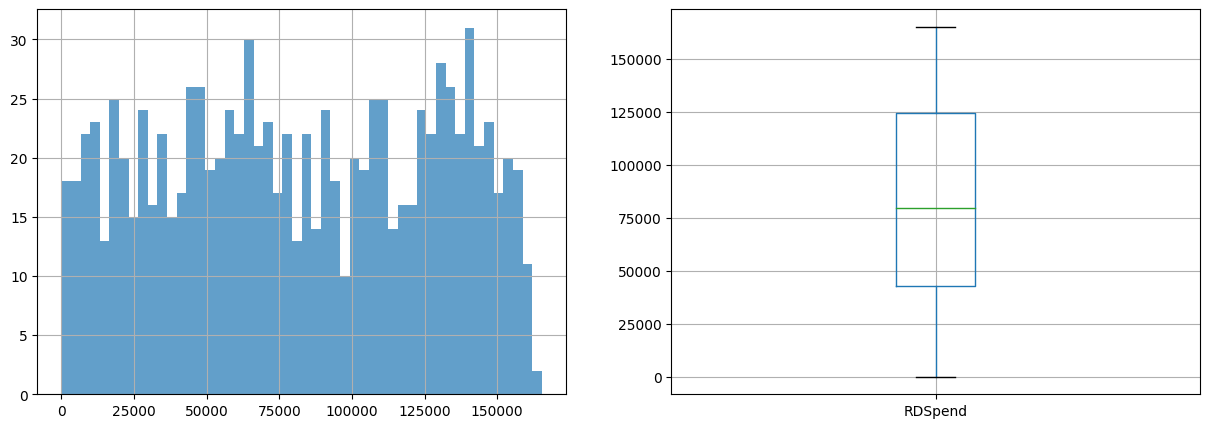

In [ ]:
# Tổng quan giá trị và ngoại lệ của RDSpend
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
rdspend_value['RDSpend'].hist(bins=50, ax=axes[0], alpha=0.7)
rdspend_value['RDSpend'].to_frame().boxplot(ax=axes[1], vert=True);

**=> không có giá trị phi logic**

## 4.2.Cột Profit

In [ ]:
# Lấy các giá trị của Profit
profit = df.rdd.map(lambda p: (p.Profit)).collect()

In [ ]:
# Đưa các giá trị vừa lấy vào dataframe
profit_value = DataFrame({'Profit':profit})

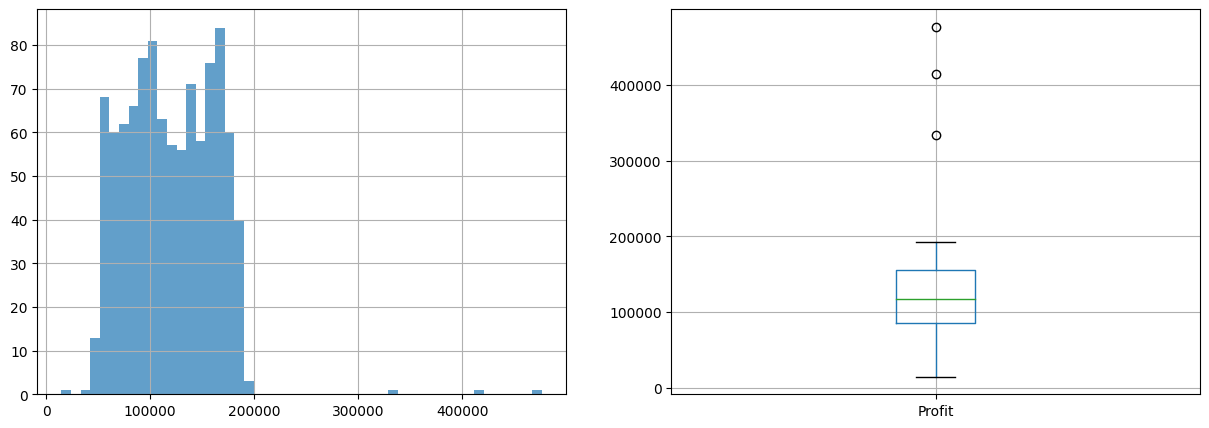

In [ ]:
# Tổng quan giá trị và ngoại lệ của Profit
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
profit_value['Profit'].hist(bins=50, ax=axes[0], alpha=0.7)
profit_value['Profit'].to_frame().boxplot(ax=axes[1], vert=True);

**=> Thấy có 3 giá trị cao hơn bất thường => kiểm tra giá trị đó (profit > 300000)**

In [ ]:
df.filter((df['Profit'] > 300000)).orderBy('Profit').show(10,True)

+---------+---------+
|  RDSpend|   Profit|
+---------+---------+
|128456.23|333962.19|
|100275.47|413956.48|
|161181.72|476485.43|
+---------+---------+



**=> Do chi phí đầu tư cũng khá cao nên việc thu lại lợi nhuận lớn cũng không có gì bất bình thường => không loại bỏ giá trị ngoại lệ**

# 5.VISUALIZATION

In [ ]:
# Lấy các giá trị của RDSpend và Profit
x = df.rdd.map(lambda p: (p.RDSpend)).collect()
y = df.rdd.map(lambda p: (p.Profit)).collect()

In [ ]:
# Đưa các giá trị vừa lấy vào dataframe
data_df = DataFrame({'rdspend': x, 'profit': y})

### 5.1.Trực quan hóa các chi phí bỏ ra để đầu tư và phát triển sản phẩm (RDSpend)

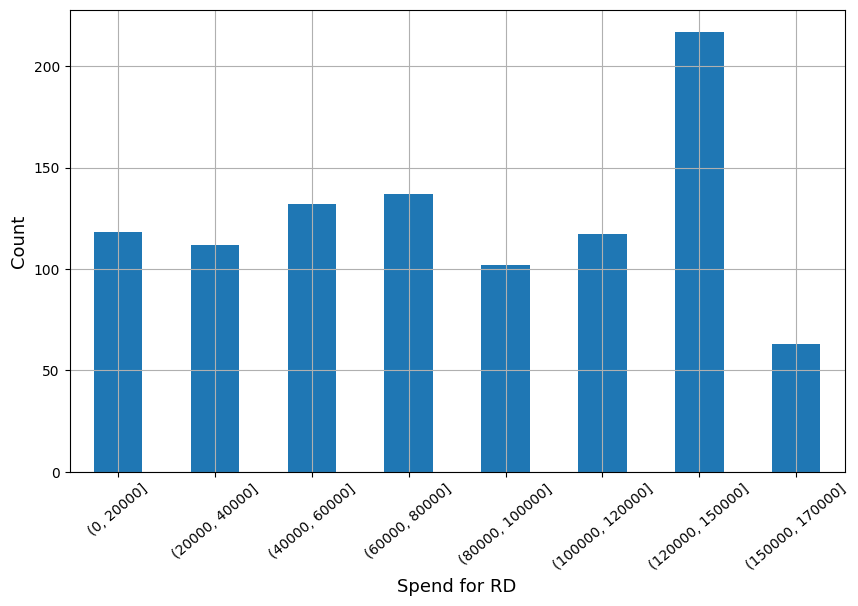

In [ ]:
data_df['rdspend_group'] = pd.cut(data_df.rdspend, bins=[0,20000,40000,60000,80000,100000,120000,150000,170000])
data_df.rdspend_group.value_counts().sort_index().plot(kind='bar', figsize=(10,6))
plt.xlabel('Spend for RD', fontsize= 13)
plt.ylabel('Count', fontsize = 13)
plt.xticks(rotation = 40)
plt.grid()
plt.show()

* Chi phí trong tầm 120k - 150k chiếm số lượng cao nhất 
* Và thấp nhất là 150k trở lên

### 5.2.Trực quan hóa giữa chi phí (RDSpend) và lợi nhuận (Profit)

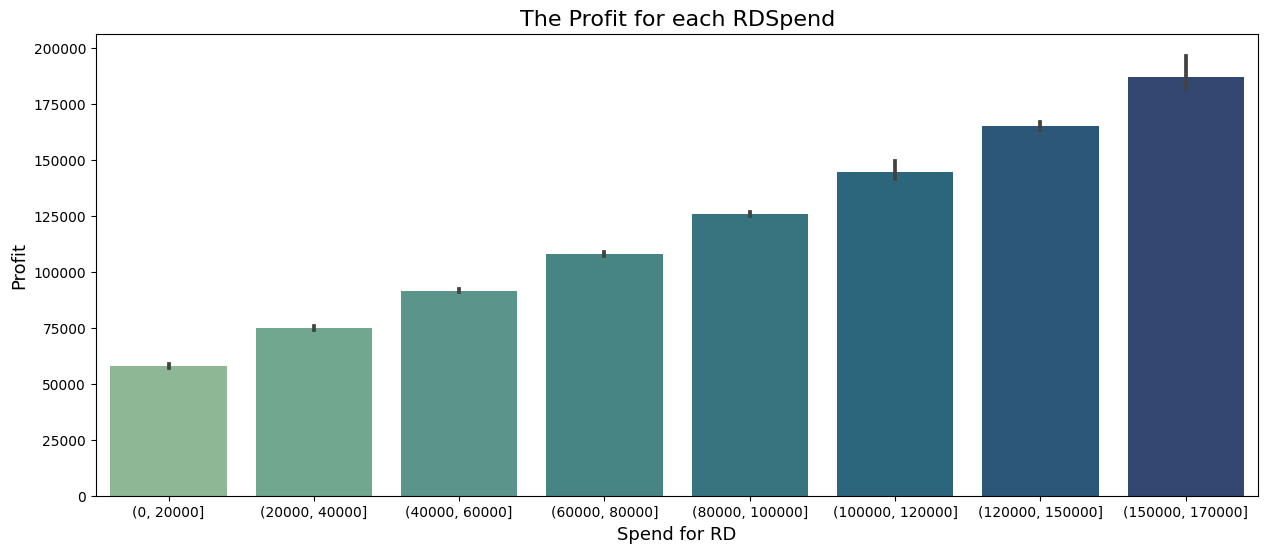

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(data = data_df, x='rdspend_group', y='profit', palette='crest')
plt.title('The Profit for each RDSpend', fontsize= 16)
plt.xlabel('Spend for RD', fontsize= 13)
plt.ylabel('Profit', fontsize = 13)
plt.show();

* Đúng như dự đoán thì chi phí bỏ ra càng cao thì lợi nhuận thu được cao nhiều

# 6.CHUẨN BỊ DỮ LIỆU

## 6.1.Chia dữ liệu thành 2 phần Feature(X) và Target(Y)

In [ ]:
df.show()

+---------+---------+
|  RDSpend|   Profit|
+---------+---------+
| 165349.2|192261.83|
| 162597.7|191792.06|
|153441.51|191050.39|
|144372.41|182901.99|
|142107.34|166187.94|
| 131876.9|156991.12|
|134615.46|156122.51|
|130298.13| 155752.6|
|120542.52|152211.77|
|123334.88|149759.96|
|101913.08|146121.95|
|100671.96| 144259.4|
| 93863.75|141585.52|
| 91992.39|134307.35|
|119943.24|132602.65|
|114523.61|129917.04|
| 78013.11|126992.93|
| 94657.16|125370.37|
| 91749.16| 124266.9|
|  86419.7|122776.86|
+---------+---------+
only showing top 20 rows



In [ ]:
# Cắt dữ liệu thành hai phần X  và y. 
df.createOrReplaceTempView("split_data")
X = spark.sql("SELECT DOUBLE(RDSpend) FROM split_data")
y = spark.sql("SELECT DOUBLE(Profit) FROM split_data")

In [ ]:
X.show(10)

+---------+
|  RDSpend|
+---------+
| 165349.2|
| 162597.7|
|153441.51|
|144372.41|
|142107.34|
| 131876.9|
|134615.46|
|130298.13|
|120542.52|
|123334.88|
+---------+
only showing top 10 rows



In [ ]:
y.show(10)

+---------+
|   Profit|
+---------+
|192261.83|
|191792.06|
|191050.39|
|182901.99|
|166187.94|
|156991.12|
|156122.51|
| 155752.6|
|152211.77|
|149759.96|
+---------+
only showing top 10 rows



## 6.2.Chia dữ liệu Train và Test theo tỉ lệ train = 70% test = 30%

In [ ]:
X_train, X_test = X.randomSplit([0.7, 0.3], seed = 2)
y_train, y_test = y.randomSplit([0.7, 0.3], seed = 2)

In [ ]:
X_train.describe().show()

+-------+-----------------+
|summary|          RDSpend|
+-------+-----------------+
|  count|              698|
|   mean|  81301.123252149|
| stddev|46348.20018060621|
|    min|              0.0|
|    max|         165349.2|
+-------+-----------------+



In [ ]:
X_test.describe().show()

+-------+-----------------+
|summary|          RDSpend|
+-------+-----------------+
|  count|              302|
|   mean|82519.01711920531|
| stddev|47038.62548681213|
|    min|           1215.0|
|    max|         162597.7|
+-------+-----------------+



In [ ]:
y_train.describe().show()

+-------+-----------------+
|summary|           Profit|
+-------+-----------------+
|  count|              698|
|   mean|119157.5400676075|
| stddev| 42650.1715799624|
|    min|          14681.4|
|    max|        476485.43|
+-------+-----------------+



In [ ]:
y_test.describe().show()

+-------+------------------+
|summary|            Profit|
+-------+------------------+
|  count|               302|
|   mean|120444.37645172192|
| stddev|43492.754490076855|
|    min|       50070.86316|
|    max|         413956.48|
+-------+------------------+



# 7.MÔ HÌNH DỰ ĐOÁN LINEAR REGRESSION (HƯỚNG LÀM 1)

## 7.1.Tạo mô hình

In [ ]:
# rdd_X_train = X_train.rdd
rdd_X_train = X_train.rdd.map(list)
rdd_y_train = y_train.rdd.map(list)

In [ ]:
# rdd_X_test = X_test.rdd
rdd_X_test = X_test.rdd.map(list)
rdd_y_test = y_test.rdd.map(list)

In [ ]:
rdd_X_train.count()

698

In [ ]:
rdd_y_train.count()

698

## 7.2.Hàm tính trung bình và mẫu số B1

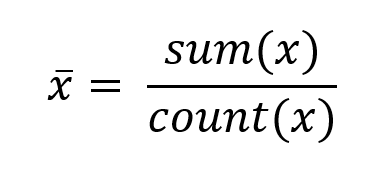

In [ ]:
# Tính giá trị trung bình của danh sách số
def mean(data):
    sum = data.reduce(lambda a, b: a + b)
    return sum / data.count()

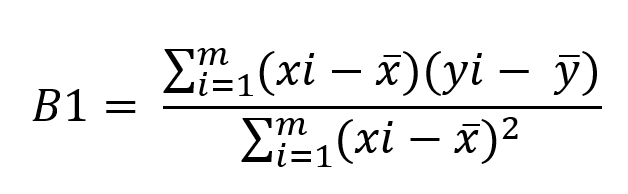

In [ ]:
# Tính mẫu số B1 (Slope)
def deno_slope(data, mean):
    deno_slope = data.map(lambda a: (a - mean) ** 2)
    result = deno_slope.reduce(lambda a, b: a + b)
    return result

## 7.3.Tính trung bình và mẫu số của X_train và y_train

#### 7.3.1.Tính cho X_train

In [ ]:
# Chuyển rdd_X_train thành danh sách các giá trị
rdd_X_train_1 = rdd_X_train.map(lambda a: a[0])

In [ ]:
# Danh sách các giá trị
rdd_X_train_1.take(10)

[0.0, 0.0, 542.05, 1000.23, 1269.0, 1315.46, 1634.0, 2296.0, 2307.0, 2603.0]

In [ ]:
# Giá trị trung bình của X_train
mean_X_train = mean(rdd_X_train_1)

In [ ]:
# Giá trị mẫu số của X_train
deno_X_train = deno_slope(rdd_X_train_1, mean_X_train)

#### 7.3.2.Tính cho y_train

In [ ]:
# Chuyển rdd_y_train thành danh sách các giá trị
rdd_y_train_1 = rdd_y_train.map(lambda a: a[0])

In [ ]:
rdd_y_train_1.take(10)

[14681.4,
 35673.41,
 42559.73,
 49490.75,
 50116.99489,
 50428.81124,
 50468.96294,
 51003.74933,
 51256.61958,
 51276.26828]

In [ ]:
# Giá trị trung bình của y_train
mean_y_train = mean(rdd_y_train_1)

In [ ]:
# Giá trị mẫu số của y_train
deno_y_train = deno_slope(rdd_y_train_1, mean_y_train)

### 7.3.3.Giá trị tính được

In [ ]:
print(">>>> X_train: Giá trị trung bình - Mean = " + str(mean_X_train) + "; Mẫu số B1 - Deno Slope = " + str(deno_X_train))
print(">>>> y_train: Giá trị trung bình - Mean = " + str(mean_y_train) + "; Mẫu số B1 - Deno Slope = " + str(deno_y_train))

>>>> X_train: Giá trị trung bình - Mean = 81301.123252149; Mẫu số B1 - Deno Slope = 1497264495007.14
>>>> y_train: Giá trị trung bình - Mean = 119157.5400676075; Mẫu số B1 - Deno Slope = 1267868883652.7605


## 7.4.Hàm tính tử số B1

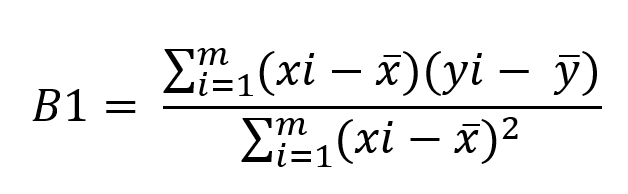

In [ ]:
# Tính tử số B1 (Slope)
def nume_slope(X, mean_X, y, mean_y):
    result = 0.0
    common_rdd = rdd_X_train_1.zip(rdd_y_train_1)
    nume_slope = common_rdd.map(lambda a: (a[0] - mean_X) * (a[1] - mean_y))
    result += nume_slope.reduce(lambda a, b: a + b)
    return result

#### Giá trị tính được

In [ ]:
# Giá trị tử số của X và y
nume_slope_xy = nume_slope(rdd_X_train_1, mean_X_train, rdd_y_train_1, mean_y_train)
print(">>>> Tử số B1 - Nume Slope = " + str(nume_slope_xy))

>>>> Tử số B1 - Nume Slope = 1320279826734.3691


## 7.5.Hàm tính toán các hệ số B1 và B0 của mô hình

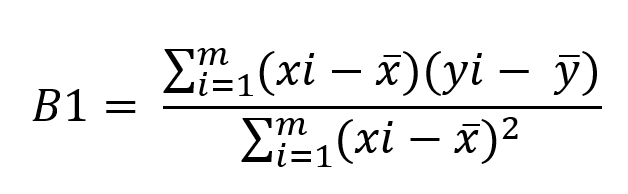

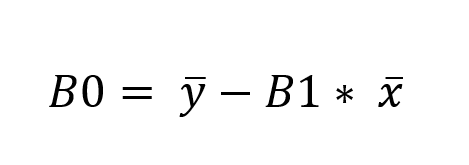

In [ ]:
# Tính toán các hệ số B0 và B1
def coefficients(X, y):
    X_mean, y_mean = mean(X), mean(y)
    b1 = nume_slope(X, X_mean, y, y_mean) / deno_slope(X, X_mean)
    b0 = y_mean - b1 * X_mean
    return [b0, b1]

In [ ]:
# Hệ số của mô hình
coef = coefficients(rdd_X_train_1, rdd_y_train_1)
print(">>>> Hệ số - B0, B1 = " + str(coef))

>>>> Hệ số - B0, B1 = [47466.64425153793, 0.8817946536079941]


## 7.6.Mô hình dự đoán

In [ ]:
# Mô hình hồi quy tuyến tính để dự đoán lợi nhuận
def simple_linear_regression(X_train, y_train, X_test):
    coef = coefficients(X_train, y_train)
    b0 = coef[0]
    b1 = coef[1]
    yhat = X_test.map(lambda a: a * b1 + b0)
    return yhat

## 7.7.Ứng dụng mô hình dự đoán trên tập Test

In [ ]:
# Chuyển rdd_X_test thành danh sách các giá trị
rdd_X_test_1 = rdd_X_test.map(lambda a: a[0])

In [ ]:
# Prediction lưu trữ kết quả dự đoán lợi nhuận
start = time.time()
prediction = simple_linear_regression(rdd_X_train_1, rdd_y_train_1, rdd_X_test_1)
end = time.time()
run_time_HL1 = end - start
print(">>>> Run time:" + str(run_time_HL1) + "(s)")

>>>> Run time:0.6315128803253174(s)


In [ ]:
# Xuất kết quả dự đoán lợi nhuận trên mô hình hồi quy tuyến tính 
prediction_result = prediction.collect()
DataFrame({'prediction_predict':prediction_result})

,prediction_predict
0,48538.024756
1,48948.941064
2,49831.617513
3,50190.507937
4,50761.910872
...,...
297,187840.416954
298,187844.825927
299,188092.610225
300,188329.812987


In [ ]:
# Chuyển rdd_y_test thành danh sách các giá trị
rdd_y_test_1 = rdd_y_test.map(lambda a: a[0])

In [ ]:
rdd_y_test_1.take(10)

[50070.86316,
 50994.35213,
 51336.06868,
 51690.5996,
 52276.64348,
 53225.76119,
 53649.48971,
 54205.63339,
 54244.9308,
 54932.63535]

## 7.8.Đánh giá mô hình bằng RMSE

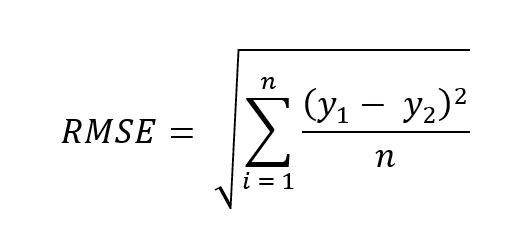

In [ ]:
from math import sqrt
# Hàm tính toán RMSE
def rmse_metric(actual, predicted):
    common_rdd = actual.zip(predicted)
    prediction_error = common_rdd.map(lambda a: a[0] - a[1])
    # prediction_error.collect()
    prediction_error_square = prediction_error.map(lambda a: a ** 2)
    sum_error = prediction_error_square.reduce(lambda a, b: a + b)
    # print(sum_error)
    mean_error = sum_error / float(actual.count())
    return sqrt(mean_error)

In [ ]:
# Hàm đánh giá thuật toán hồi quy trên tập dữ liệu huấn luyện
def evaluate_algorithm(X_train, y_train, X_test, y_test, algorithm):
    predicted = algorithm(X_train, y_train, X_test)
    rmse = rmse_metric(y_test, predicted)
    return rmse

In [ ]:
# Đánh giá thuật toán hồi quy trên tập dữ liệu huấn luyện
evaluate_model_HL1 = evaluate_algorithm(rdd_X_train_1, rdd_y_train_1, rdd_X_test_1, rdd_y_test_1, simple_linear_regression)
print(">>>> Root Mean Squared Error = " + str(evaluate_model_HL1))

>>>> Root Mean Squared Error = 12920.51372601141


## 7.9.So sánh kết quả dự đoán và thực tế

In [ ]:
y_test_origin = rdd_y_test_1.collect()

In [ ]:
y_test_origin

[50070.86316,
 50994.35213,
 51336.06868,
 51690.5996,
 52276.64348,
 53225.76119,
 53649.48971,
 54205.63339,
 54244.9308,
 54932.63535,
 55227.36587,
 55623.75707,
 56138.89476,
 56788.15621,
 56991.47755,
 57893.60924,
 58605.23395,
 59225.44949,
 59328.81874,
 59342.48741,
 59784.15604,
 59803.80475,
 60243.7648,
 60947.70089,
 61393.64099,
 62531.55709,
 63742.94226,
 63978.72668,
 65219.15775,
 65471.1737,
 65743.69265,
 67282.27141,
 67733.33725,
 68575.66854,
 68705.52083,
 68872.96194,
 68984.01982,
 70244.95388,
 70509.78421,
 72337.96774,
 72478.92582,
 72735.21323,
 73154.67029,
 73577.54452,
 73790.26307,
 73850.06347,
 73872.27504,
 74052.53052,
 74324.19518,
 75297.23305,
 75445.02546,
 75968.70607,
 76017.40068,
 76229.26494,
 76376.20305,
 76487.26093,
 76644.45054,
 77627.73991,
 77798.83,
 79170.59013,
 79794.22283,
 79796.7857,
 79808.74578,
 80045.38449,
 80066.74177,
 80229.05713,
 80504.99325,
 80539.1649,
 80804.84952,
 80859.52417,
 81580.54608,
 83178.92524,
 

In [ ]:
# So sánh giữa giá trị Profit dự đoán và giá trị gốc
compare = DataFrame({'Origin': y_test_origin, 'Predict': prediction_result})
compare.head(10)

,Origin,Predict
0,50070.86316,48538.024756
1,50994.35213,48948.941064
2,51336.06868,49831.617513
3,51690.59960,50190.507937
4,52276.64348,50761.910872
5,53225.76119,51745.111911
6,53649.48971,52060.794397
7,54205.63339,52716.849619
8,54244.93080,52805.910879
9,54932.63535,52903.790086


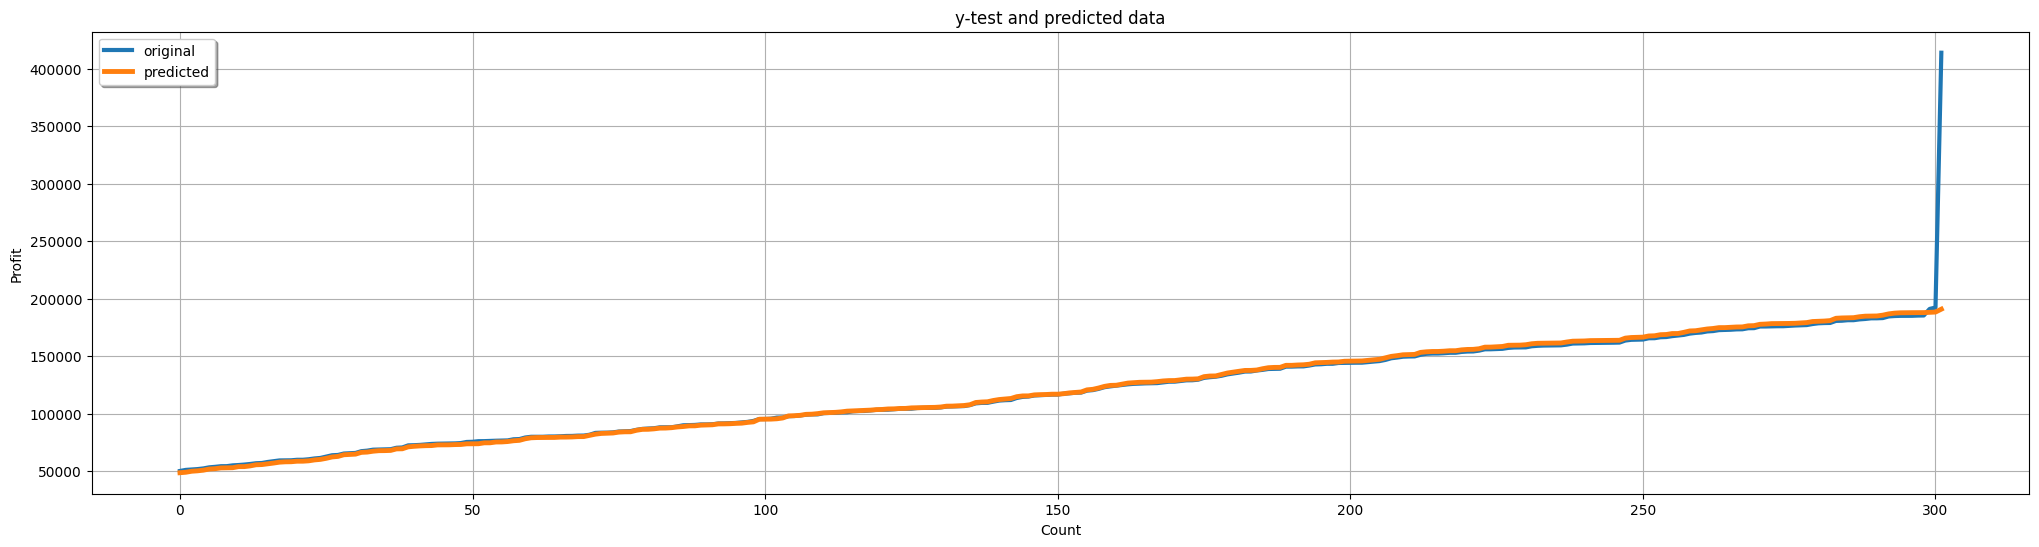

In [ ]:
# Trực quan hóa so sánh kết quả trên tập test và kết quả dự đoán
x_ax = range(len(y_test_origin))
plt.figure(figsize=(25, 6))
plt.plot(x_ax, y_test_origin, linewidth=3, label="original")
plt.plot(x_ax, prediction_result, linewidth=3.5, label="predicted")
plt.title("y-test and predicted data")
plt.xlabel('Count')
plt.ylabel('Profit')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

# 8.MÔ HÌNH DỰ ĐOÁN LINEAR REGRESSION (HƯỚNG LÀM 2)

## 8.1.Tạo mô hình

In [ ]:
# Tạo 2 tập Train và Test bằng zip => mỗi dòng sẽ là 1 cặp key-value
rdd_train = rdd_X_train_1.zip(rdd_y_train_1)
rdd_test = rdd_X_test_1.zip(rdd_y_test_1)

In [ ]:
rdd_train.count()

698

In [ ]:
rdd_test.count()

302

## 8.2.Hàm tính toán các hệ số B1 và B0 của mô hình

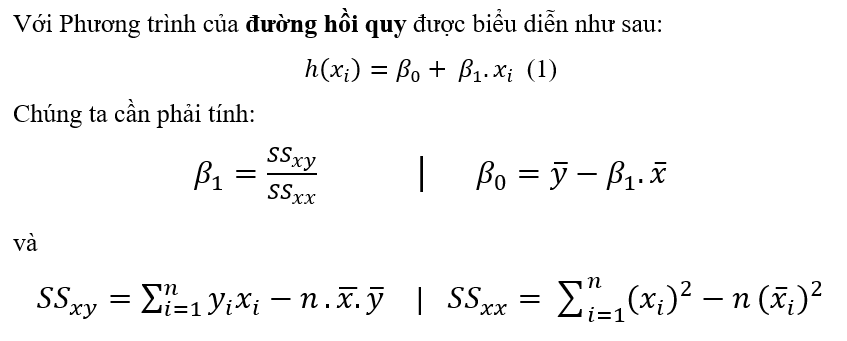

In [ ]:
# Tính toán giá trị trung bình của mảng
# Đầu vào sẽ là 1 tuple (key-value)
def estimate_coef(data):
    # Số lượng phần tử trong m
    n = data.count()
    
    # Trung bình của mảng bao gồm các keys
    sum_x = data.keys().reduce(lambda a, b: a + b)
    mean_x = sum_x/n
    # Trung bình của mảng bao gồm các values
    sum_y = data.values().reduce(lambda a, b: a + b)
    mean_y = sum_y/n
    
    # Tính toán giá trị cross-deviation (độ lệch chéo) và deviation của x và y
    sum_xy = data.map(lambda x: (x[0],x[0]*x[1])).values().reduce(lambda x,y: x+y)
    SS_xy = sum_xy - n*mean_x*mean_y
    
    sum_xx = data.map(lambda x: (x[0],x[0]*x[0])).values().reduce(lambda x,y: x+y)
    SS_xx = sum_xx - n*mean_x*mean_x
    
    # Tính toán hệ số hồi quy
    b_1 = SS_xy / SS_xx
    b_0 = mean_y - b_1*mean_x
    
    return (b_0, b_1)

## 8.3.Tính hệ số B1 và B0

In [ ]:
# Hệ số ước lượng (estimating coefficients)
b = estimate_coef(rdd_train)
print("Hệ số ước lượng:\nb_0 = {} \nb_1 = {}".format(b[0], b[1]))

Hệ số ước lượng:
b_0 = 47466.644251537975 
b_1 = 0.8817946536079935


## 8.4.Mô hình dự đoán

In [ ]:
# Hàm dự đoán - trả về các giá trị y 
def simple_linear_regression(train, test):
    b_0, b_1 = estimate_coef(train)
    predictions = test.keys().map(lambda x: x*b_1 + b_0)
    return predictions

## 8.5.Ứng dụng mô hình dự đoán trên tập Test

In [ ]:
start = time.time()
prediction = simple_linear_regression(rdd_train, rdd_test)
end = time.time()
run_time_HL2 = end - start
print(">>>> Run time:" + str(run_time_HL2) + "(s)")

>>>> Run time:0.5445091724395752(s)


## 8.6.Đánh giá mô hình bằng RMSE

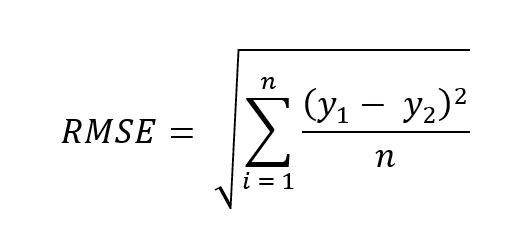

In [ ]:
# Hàm tính toán RMSE 
def rmse_metric(actual, predict):
    rdd_zip = actual.zip(predict)
    
    predict_error = rdd_zip.map(lambda a: a[0] - a[1])
    predict_error_square = predict_error.map(lambda a: a**2)
    
    sum_error = predict_error_square.reduce(lambda a,b: a+b)
    #print(sum_error)
    
    mean_error = sum_error/float(actual.count())
    
    rmse = math.sqrt(mean_error)
    return rmse

In [ ]:
# Hàm đánh giá thuật toán hồi quy trên tập dữ liệu huấn luyện
def evaluate_algorithm(train, test):
    y_test = test.values()
    y_predict = simple_linear_regression(train, test)
    rmse = rmse_metric(y_test, y_predict)
    return rmse

In [ ]:
# Đánh giá thuật toán hồi quy trên tập dữ liệu huấn luyện
import math 
evaluate_model_HL2 = evaluate_algorithm(rdd_train, rdd_test)
print("Chỉ số RMSE: {} ".format(evaluate_model_HL2))

Chỉ số RMSE: 12920.51372601141 


## 8.7.So sánh kết quả dự đoán được và thực tế

In [ ]:
y_test = rdd_test.values().collect()

In [ ]:
y_predict = simple_linear_regression(rdd_train, rdd_test).collect()

In [ ]:
compare = DataFrame({'Origin': y_test, 'Predict': y_predict})
compare.head(10)

,Origin,Predict
0,50070.86316,48538.024756
1,50994.35213,48948.941064
2,51336.06868,49831.617513
3,51690.59960,50190.507937
4,52276.64348,50761.910872
5,53225.76119,51745.111911
6,53649.48971,52060.794397
7,54205.63339,52716.849619
8,54244.93080,52805.910879
9,54932.63535,52903.790086


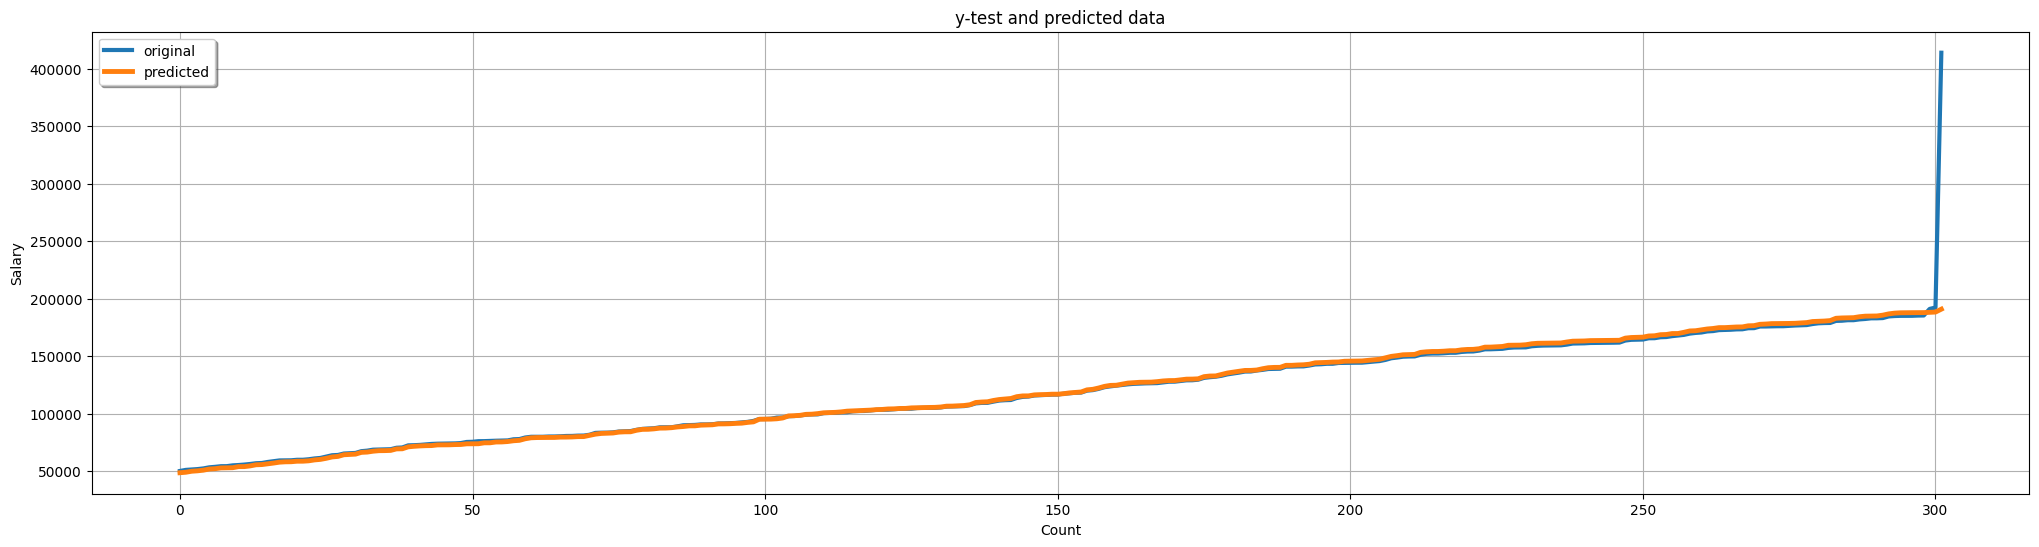

In [ ]:
# Trực quan hóa so sánh kết quả trên tập test và kết quả dự đoán
x_ax = range(len(y_test))
plt.figure(figsize=(25, 6))
plt.plot(x_ax, y_test, linewidth=3, label="original")
plt.plot(x_ax, y_predict, linewidth=3.5, label="predicted")
plt.title("y-test and predicted data")
plt.xlabel('Count')
plt.ylabel('Salary')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

# 9.MÔ HÌNH DỰ ĐOÁN LINEAR REGRESSION (SỬ DỤNG MLLIB)

## 9.1.Chuẩn bị dữ liệu

In [ ]:
# Zip X_test và y_test lưu vào rdd_data_MML
rdd_data_MML = rdd_X_test_1.zip(rdd_y_test_1)

In [ ]:
# Tên cột khi chuyển đổi từ RDD sang Dataframe
nameColumns = ["RDSpend", "label"]

In [ ]:
# Chuyển đổi rdd_data_MML sang Dataframe và lưu vào data_MML
data_MML = rdd_data_MML.toDF(nameColumns)

In [ ]:
# Thêm lớp LinearRegression từ thư viện máy học
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["RDSpend"],
    outputCol="features")
data_MML = assembler.transform(data_MML)

In [ ]:
data_MML.show()

+-------+-----------+---------+
|RDSpend|      label| features|
+-------+-----------+---------+
| 1215.0|50070.86316| [1215.0]|
| 1681.0|50994.35213| [1681.0]|
| 2682.0|51336.06868| [2682.0]|
| 3089.0| 51690.5996| [3089.0]|
| 3737.0|52276.64348| [3737.0]|
| 4852.0|53225.76119| [4852.0]|
| 5210.0|53649.48971| [5210.0]|
| 5954.0|54205.63339| [5954.0]|
| 6055.0| 54244.9308| [6055.0]|
| 6166.0|54932.63535| [6166.0]|
| 7214.0|55227.36587| [7214.0]|
| 7251.0|55623.75707| [7251.0]|
| 7959.0|56138.89476| [7959.0]|
| 9063.0|56788.15621| [9063.0]|
| 9261.0|56991.47755| [9261.0]|
| 9960.0|57893.60924| [9960.0]|
|10758.0|58605.23395|[10758.0]|
|11624.0|59225.44949|[11624.0]|
|11977.0|59328.81874|[11977.0]|
|12052.0|59342.48741|[12052.0]|
+-------+-----------+---------+
only showing top 20 rows



In [ ]:
data_MML.describe().show()

+-------+-----------------+------------------+
|summary|          RDSpend|             label|
+-------+-----------------+------------------+
|  count|              302|               302|
|   mean|82519.01711920531|120444.37645172192|
| stddev|47038.62548681213|43492.754490076855|
|    min|           1215.0|       50070.86316|
|    max|         162597.7|         413956.48|
+-------+-----------------+------------------+



## 9.2.Ứng dụng mô hình dự đoán trên tập Test

In [ ]:
from pyspark.ml.regression import LinearRegression

start = time.time()
#Tạo biến LinearRegression để sử dụng
lr = LinearRegression()

#Tạo ra hai mô hình tương ứng với hai tham số
modelA = lr.fit(data_MML, {lr.regParam:0.0})

predictionsA = modelA.transform(data_MML)
end = time.time()
run_time_HL3 = end - start
print(">>>> Run time:" + str(run_time_HL3) + "(s)")

22/12/19 03:53:18 WARN Instrumentation: [53b965f9] regParam is zero, which might cause numerical instability and overfitting.


>>>> Run time:3.170637369155884(s)


In [ ]:
#Hiển thị thông tin của hai mô hình
print(">>>> Model intercept: {}, coefficient: {}".format(modelA.intercept, modelA.coefficients[0]))

>>>> Model intercept: 47601.040120002785, coefficient: 0.8827460490288087


In [ ]:
predictionsA.show()

+-------+-----------+---------+------------------+
|RDSpend|      label| features|        prediction|
+-------+-----------+---------+------------------+
| 1215.0|50070.86316| [1215.0]| 48673.57656957279|
| 1681.0|50994.35213| [1681.0]|49084.936228420214|
| 2682.0|51336.06868| [2682.0]| 49968.56502349805|
| 3089.0| 51690.5996| [3089.0]| 50327.84266545277|
| 3737.0|52276.64348| [3737.0]|50899.862105223445|
| 4852.0|53225.76119| [4852.0]| 51884.12394989056|
| 5210.0|53649.48971| [5210.0]|52200.147035442875|
| 5954.0|54205.63339| [5954.0]| 52856.91009592031|
| 6055.0| 54244.9308| [6055.0]| 52946.06744687222|
| 6166.0|54932.63535| [6166.0]| 53044.05225831442|
| 7214.0|55227.36587| [7214.0]| 53969.17011769661|
| 7251.0|55623.75707| [7251.0]| 54001.83172151068|
| 7959.0|56138.89476| [7959.0]|54626.815924223076|
| 9063.0|56788.15621| [9063.0]|55601.367562350875|
| 9261.0|56991.47755| [9261.0]|55776.151280058584|
| 9960.0|57893.60924| [9960.0]| 56393.19076832972|
|10758.0|58605.23395|[10758.0]|

## 9.3.Đánh giá mô hình bằng RMSE

In [ ]:
#Thêm lớp RegressionEvaluator từ thư viện máy học
from pyspark.ml.evaluation import RegressionEvaluator

#Sử dụng phương pháp tính Root Mean Squared Error để đánh giá kết quả mô hình
evaluator = RegressionEvaluator(metricName="rmse")
evaluate_model_HL3 = evaluator.evaluate(predictionsA)
print(">>>> Model: Root Mean Squared Error = " + str(evaluate_model_HL3))

>>>> Model: Root Mean Squared Error = 12918.682233714082


## 9.4.So sánh kết quả dự đoán được và thực tế

In [ ]:
predictionsA.createOrReplaceTempView("predictionsA")
prediction_result_MML = spark.sql("SELECT label, prediction FROM predictionsA")

In [ ]:
# Đưa giá trị Salary test và Salary dự đoán vào DataFrame để tiến hành so sánh và trực quan hóa
prediction_result_MML.toPandas().head()

,label,prediction
0,50070.86316,48673.576570
1,50994.35213,49084.936228
2,51336.06868,49968.565023
3,51690.59960,50327.842665
4,52276.64348,50899.862105


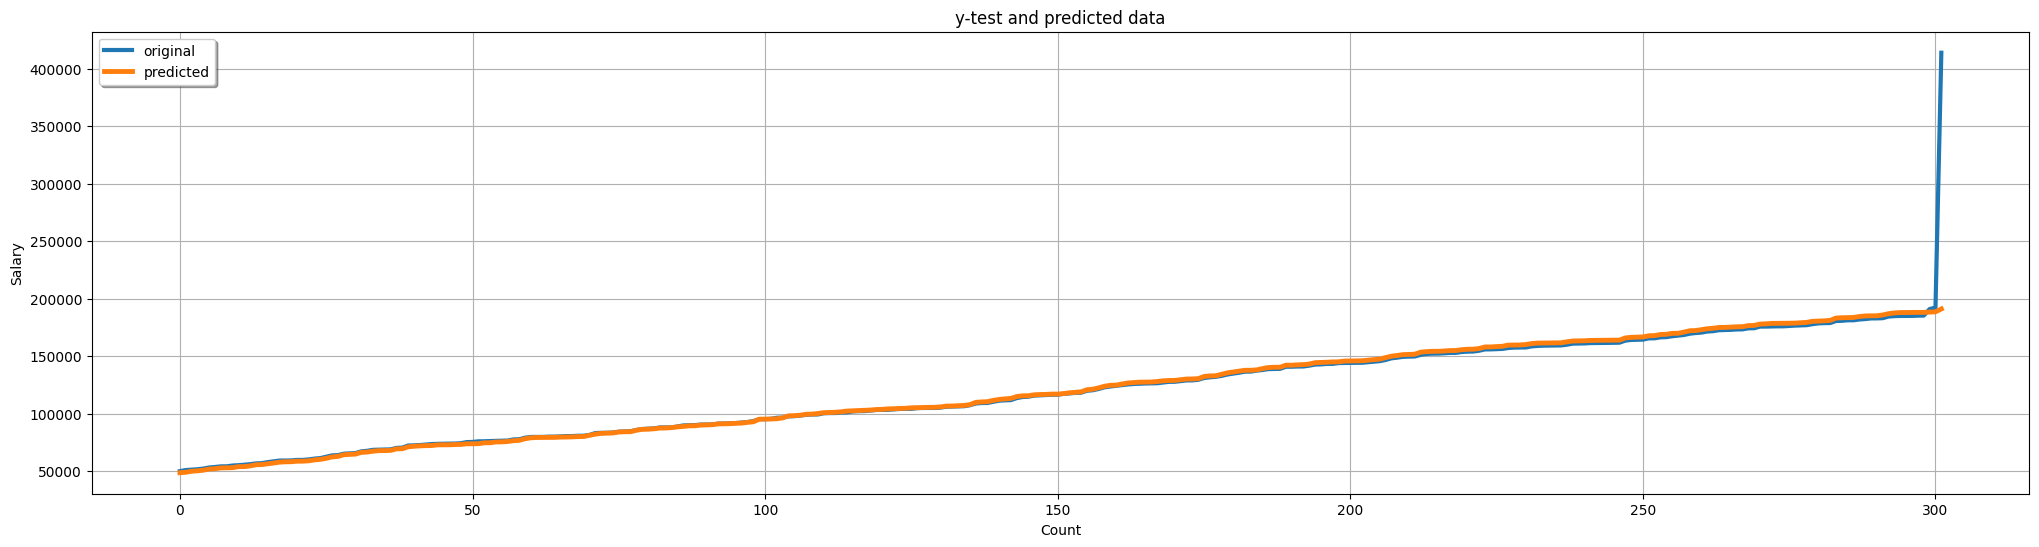

In [ ]:
# Trực quan hóa so sánh kết quả trên tập test và kết quả dự đoán
x_ax = range(len(prediction_result_MML.toPandas()['label']))
plt.figure(figsize=(25, 6))
plt.plot(x_ax, prediction_result_MML.toPandas()['label'], linewidth=3, label="original")
plt.plot(x_ax, prediction_result_MML.toPandas()['prediction'], linewidth=3.5, label="predicted")
plt.title("y-test and predicted data")
plt.xlabel('Count')
plt.ylabel('Salary')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

# 10.SO SÁNH THUẬT TOÁN

## 10.1.Thời gian chạy

In [ ]:
run_time_HL1, run_time_HL2, run_time_HL3

(0.6315128803253174, 0.5445091724395752, 3.170637369155884)

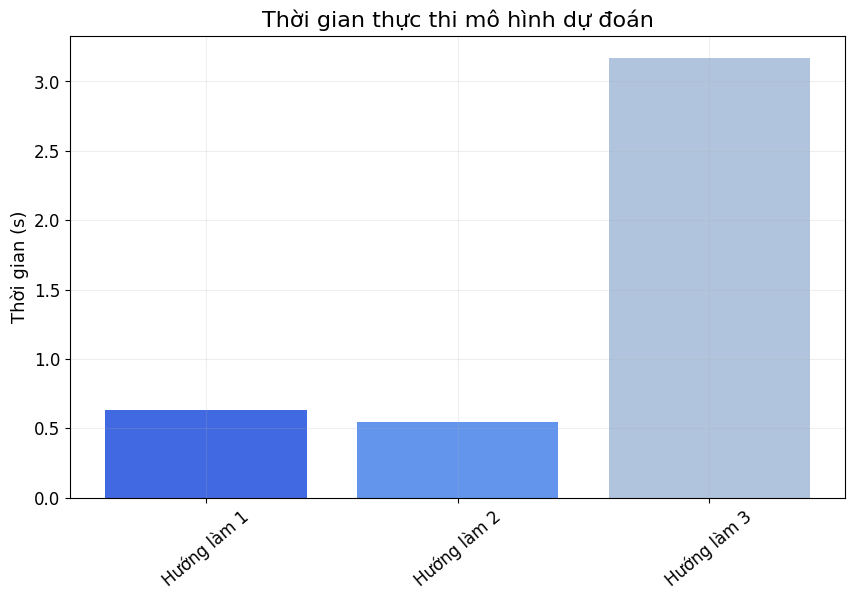

In [ ]:
# Create a dataset
run_time = [run_time_HL1, run_time_HL2, run_time_HL3]
bars = ('Hướng làm 1', 'Hướng làm 2', 'Hướng làm 3')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.figure(figsize=(10,6))
plt.bar(x_pos, run_time, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])

# Create names on the x-axis
plt.title('Thời gian thực thi mô hình dự đoán', fontsize= 16)
plt.ylabel("Thời gian (s)",fontsize=13)
plt.xticks(x_pos, bars, fontsize=12, rotation = 40)
plt.yticks(fontsize=12)
plt.grid(alpha=0.2)
plt.show();

# Show graph
plt.show()

## 10.2.Độ chính xác thông qua chỉ số RMSE

In [ ]:
evaluate_model_HL1, evaluate_model_HL2, evaluate_model_HL3

(12920.51372601141, 12920.51372601141, 12918.682233714082)

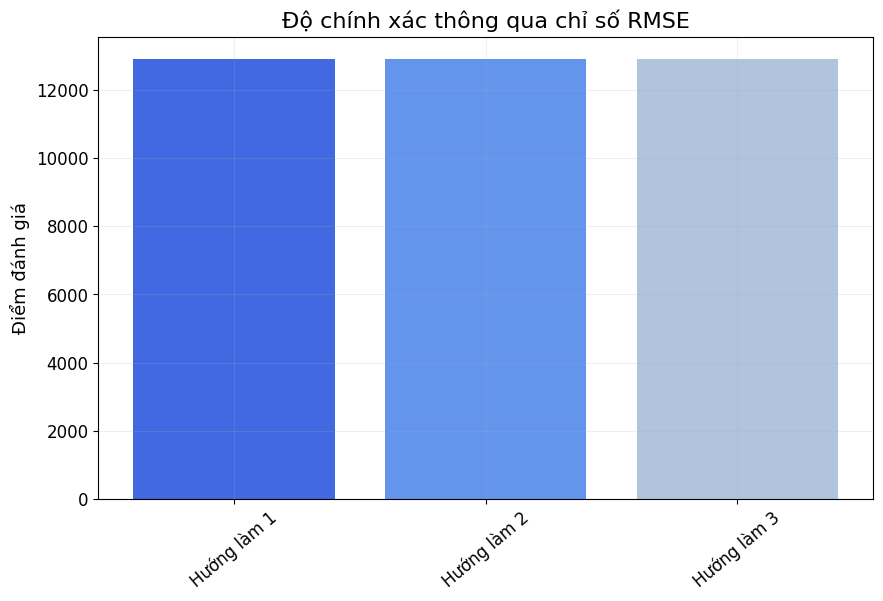

In [ ]:
# create a dataset
run_time = [evaluate_model_HL1, evaluate_model_HL2, evaluate_model_HL3]
bars = ('Hướng làm 1', 'Hướng làm 2', 'Hướng làm 3')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.figure(figsize=(10,6))
plt.bar(x_pos, run_time, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])

# Create names on the x-axis
plt.title('Độ chính xác thông qua chỉ số RMSE', fontsize= 16)
plt.ylabel("Điểm đánh giá",fontsize=13)
plt.xticks(x_pos, bars, fontsize=12, rotation = 40)
plt.yticks(fontsize=12)
plt.grid(alpha=0.2)
plt.show();

# Show graph
plt.show()

## 10.3.Độ chính xác thông qua trực quan dữ liệu 

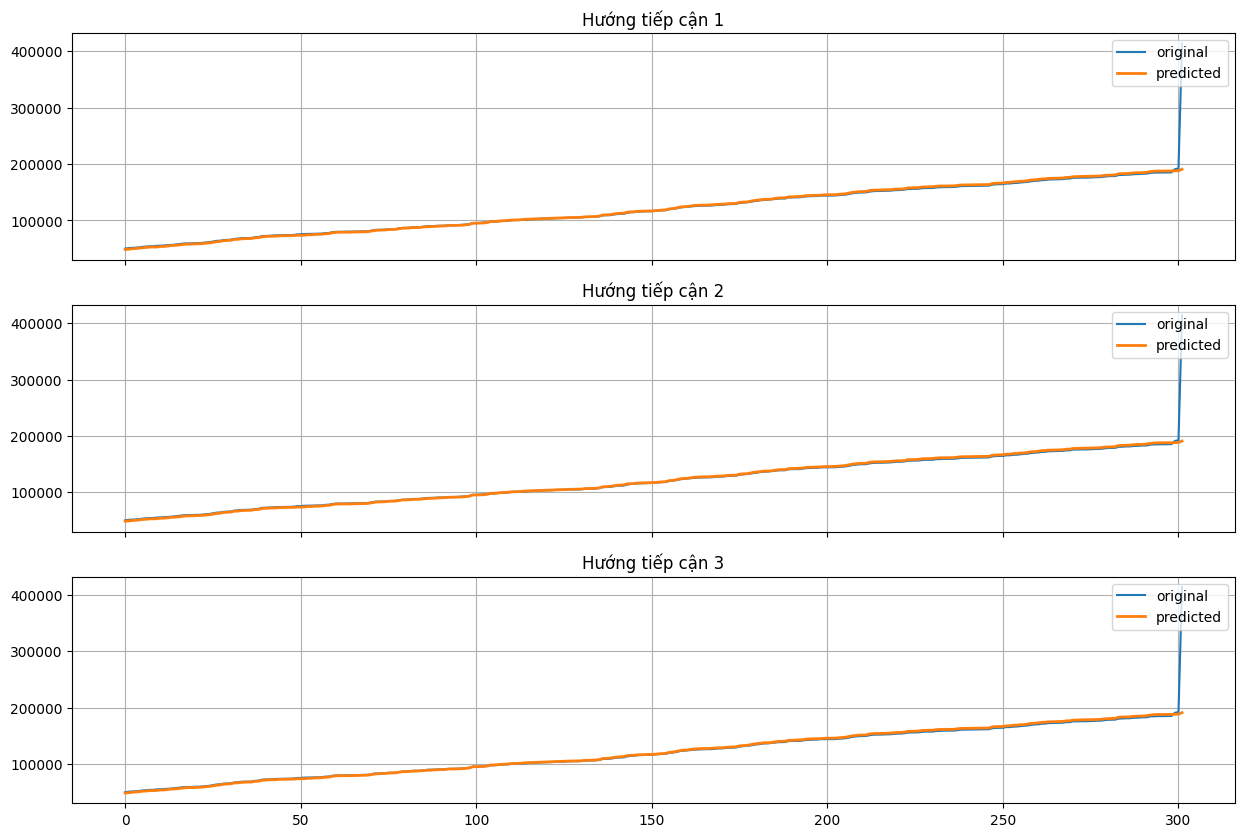

In [ ]:
cols = [prediction_result, y_predict, prediction_result_MML.toPandas()['prediction']]
name = ['Hướng tiếp cận 1', 'Hướng tiếp cận 2', 'Hướng tiếp cận 3']
x_ax = range(len(y_test))

fig, ax = plt.subplots(3, 1, figsize=(15, 10))   
a = 0
for i in range(len(ax)): 
    ax[i].set_title(name[a])
    ax[i].plot(x_ax, y_test, linewidth=1.5, label="original")
    ax[i].plot(x_ax, cols[a], linewidth=2, label="predicted")
    ax[i].grid(True)
    ax[i].legend(loc="upper right")
    ax[i].label_outer()
    a = a + 1
plt.show() 